### Problem 2: SARSA and Q-Learning (Tabular and Linear function approximation)

The problem is to implement the tabular and linear function approximation algorithms for SARSA and Q-learning for the gridworld problem. For each algorithm, I have shown the plots for discounted rewards obtained across episodes and the optimal policy learnt by the agent using the respective algorithm. For linear function approximation, I have used identity feature for each state action pair and the encoding is a binary representation of which feature(or state action pair) is present. So, the encoding of a state action pair is a binary vector of length 136( there are 34 states and 4 actions. So, 34 * 4 = 136 state action pairs) where every element is zero except the index corresponding to that state action pair. Further, I optimized the epsilon value using decaying epsilon as $\epsilon_t = \frac{\epsilon_0}{t^{0.25}}$ where t is the episode number. I am starting with a high epsilon value of 0.99 which decays to an epsilon value of around 0.25 after 200 episodes. This was needed to ensure that all states are visited often enough. I experimented with lower epsilon values but then the corner states of (6,1) , (6,2) etc were not visited enough and hence a good policy was not learnt for those states. This tuning helped in the agent to learn a policy to reach the goal state from any state in the gridworld and also to avoid the state (6,3) which incurs a negative reward. 

In [1]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
#building the environment
class Environment:
    def __init__(self, M,N, holes, terminal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.shape = (M,N)
        self.holes = holes
        self.terminal_state = terminal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
        self.prob_agent_action = [0.8, 0.1, 0.05, 0.05]
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state == (6,3):
                r[state] = -15
            elif state == (6,6):
                r[state] = 15
            else:
                r[state] = 0
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner_and_hole((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'
    
    def check_corner_and_hole(self, s): 
        #function to check if the updates state goes out of the gridworld or goes into holes. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        x1, y1 = s
        stay_same = False
        for hole in self.holes:
            if (x1,y1) == hole:
                stay_same = True

        if x1<1 or x1>6:
            stay_same = True
        if y1<1 or y1>6:
            stay_same = True
        
        return stay_same
    
    def get_new_state(self, s, a): 
        #this is the function to take the agent to an update state given the agent's choice of action and current state.
        #This encapsulates the dynamics of the environment and is not known to the agent. The agent only
        #produces the current state s and his choice of action a, to which the environment returns his new state s1.
        x, y = s
        t = random.random()
        
        if t<=0.8: #agent's action succeeds
            s_new = self.agent_move(s,a)
        
        elif 0.8<t<=0.9: #agent stays in same state
            s_new = s
        
        elif 0.9<t<=0.95: #move in a 90 degree clockwise direction
            a1 = self.move_clockwise90(a)
            s_new = self.agent_move(s, a1)
        else: #move in a -90 degree clockwise direction
            a1 = self.move_anti_clockwise90(a)
            s_new = self.agent_move(s, a1)
            
            
        r = self.rewards[s_new]
        return (s_new, r)
            

In [3]:
gridworld = Environment(6,6 , [(4,3),(5,3)], (6,6))

#### 1) Tabular SARSA

In [4]:
#building the SARSA Agent
class SARSA_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.Q = self.initialize_value_states(env)
        self.alpha = alpha
        self.initial_epsilon = epsilon
        self.epsilon = self.initial_epsilon
        
    def initialize_value_states(self, env):
        #function to initialize the value of the state action pairs
        q_s = {}
        for state in env.states:
            q_s[state] = {}
            for action in self.actions:
                q_s[state][action] = 0
        return q_s

    def find_a_stars(self, s):
        #function to find the best action(s) for a state s according to the Q(s,a) values.
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            if self.Q[s][a] > best_q_val:
                best_q_val = self.Q[s][a]
                greedy_actions = [a]
            elif self.Q[s][a] == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        #function to reset the agent between trials
        self.epsilon = agent.initial_epsilon
        self.Q = self.initialize_value_states(env)
        
    def choose_eps_greedy_action(self, s):
        #function to choose an action a for a state s using the epsilon greedy policy based on Q values
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def SARSA_update(self, env, start_state = (1,1)):
        #function for SARSA on policy update of q values for an episode
        s = start_state
        rewards = []
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            
            #observe state s1 and reward r
            s1, r = env.get_new_state(s,a)
            rewards.append(r)
            
            #choose action a1 using same epsilon greedy policy based on Q values
            a1 = self.choose_eps_greedy_action(s1)
            
            #TD update
            delta_t = (r + (self.gamma*self.Q[s1][a1])) - self.Q[s][a]
            self.Q[s][a] = self.Q[s][a] + (self.alpha*delta_t)
            
            s = s1
            a = a1
        
        #compute discounted reward
        G = 0
        T = len(rewards)
        for t in range(T-1, -1, -1):
            G = self.gamma * G + rewards[t]
            
        return G
        
    def play(self, env, episodes = 200):
        #function to play the agent for 200 episodes
        returns = []
        for episode_no in range(episodes):
            G = self.SARSA_update(env)
            returns.append(G)
            #decay epsilon 
            self.epsilon = self.initial_epsilon/np.power((episode_no + 1), 0.25)
            
        return returns
        
    def plot_optimal_policy(self, env):
        #function to plot the optimal policy learnt by the agent
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                     value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_a_stars(s)
                    value = value + '\n\n' + ','.join(move)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])

#### Learning curve for Tabular SARSA with discounted rewards (averaged over trials) vs episode number

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:28<00:00, 11.36it/s]


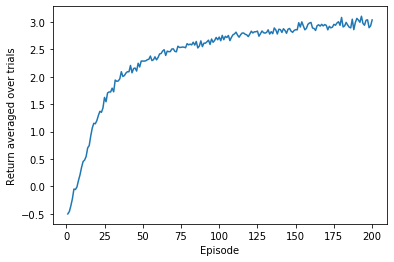

In [5]:
agent = SARSA_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
trials = 1000
episodes = 200
returns_episodes = []
for trial in tqdm(range(trials)):
    returns = agent.play(gridworld, episodes = episodes)
    returns_episodes.append(returns)
    agent.reset(gridworld)
    
returns_episodes = np.array(returns_episodes)
returns_episodes = np.mean(returns_episodes, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

In [7]:
returns_comp = {}
returns_comp['Tabular_SARSA'] = returns_episodes

#### Optimal policy learnt by Tabular SARSA after 200 episodes

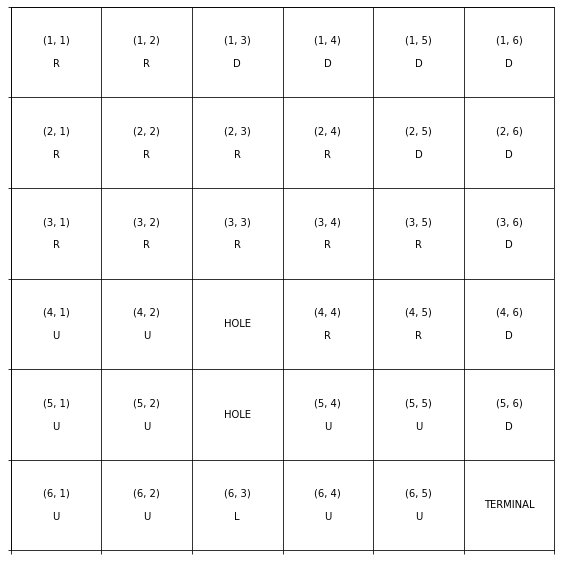

In [9]:
agent = SARSA_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
returns = agent.play(gridworld, episodes = 200)
agent.plot_optimal_policy(gridworld)

### 2)Tabular Q-Learning

In [10]:
#building the tabular Q learning agent
class Q_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.Q = self.initialize_value_states(env)
        self.alpha = alpha
        self.initial_epsilon = epsilon
        self.epsilon = self.initial_epsilon
        
    def initialize_value_states(self, env):
        #function to initialize the value of the state action pairs
        q_s = {}
        for state in env.states:
            q_s[state] = {}
            for action in self.actions:
                q_s[state][action] = 0
        return q_s

    def find_a_stars(self, s):
        #function to find the best action(s) for a state s according to the Q(s,a) values.
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            if self.Q[s][a] > best_q_val:
                best_q_val = self.Q[s][a]
                greedy_actions = [a]
            elif self.Q[s][a] == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        #function to reset the agent parameters after a trial
        self.epsilon = agent.initial_epsilon
        self.Q = self.initialize_value_states(env)
        
    def choose_eps_greedy_action(self, s):
        #function to choose an action given a state s in an epsilon greedy manner.
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def Q_update(self, env, start_state = (1,1)):
        #function for TD off policy update of q values (Q-learning) for an episode
        s = start_state
        rewards = []
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            
            #observe new state s1 and reward r
            s1, r = env.get_new_state(s,a)
            
            rewards.append(r)
            
            #choose greedy action a1 from s1 having highest Q value
            a_stars = self.find_a_stars(s1)
            a_star = a_stars[0]
            
            # TD update
            delta_t = (r + (self.gamma*self.Q[s1][a_star])) - self.Q[s][a]
            self.Q[s][a] = self.Q[s][a] + (self.alpha*delta_t)
            
            s = s1
        
        #computing discounted reward
        G = 0
        T = len(rewards)
        for t in range(T-1, -1, -1):
            G = self.gamma * G + rewards[t]
            
        return G
        
    def play(self, env, episodes = 200):
        #function to play the Q learning algorithm for 200 episodes
        returns = []
        for episode_no in range(episodes):
            G = self.Q_update(env)
            returns.append(G)
            #decay epsilon 
            self.epsilon = self.initial_epsilon/np.power((episode_no + 1), 0.25)
        
        return returns
        
    def plot_optimal_policy(self, env):
        #function to plot the optimal policy learnt by the agent
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                     value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_a_stars(s)
                    value = value + '\n\n' + ','.join(move)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])

#### Learning curve for Tabular Q-Learning with discounted rewards (averaged over trials) vs episode number

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:09<00:00, 14.33it/s]


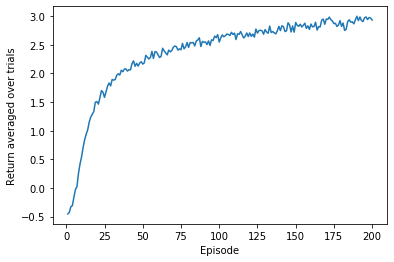

In [11]:
agent = Q_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
trials = 1000
episodes = 200
returns_episodes = []
for trial in tqdm(range(trials)):
    returns = agent.play(gridworld, episodes = episodes)
    returns_episodes.append(returns)
    agent.reset(gridworld)
    
returns_episodes = np.array(returns_episodes)
returns_episodes = np.mean(returns_episodes, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

In [12]:
returns_comp['Tabular_Q'] = returns_episodes

#### Optimal policy learnt by Tabular Q-learning agent after 200 episodes

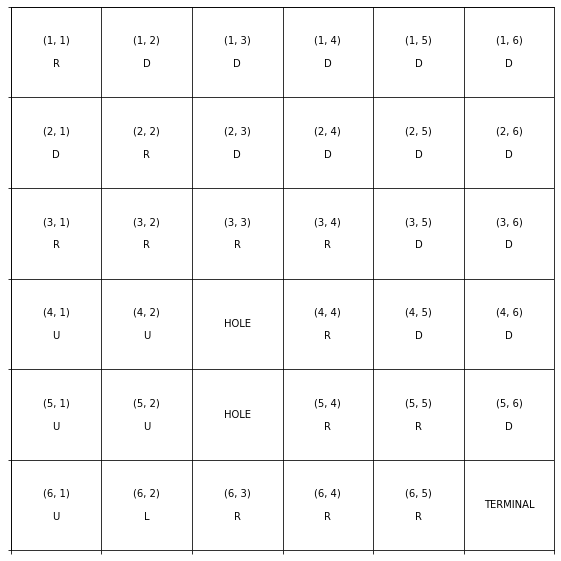

In [15]:
returns = agent.play(gridworld, episodes = 200)
agent.plot_optimal_policy(gridworld)

### 3) Linear approximation SARSA

In [16]:
#building the SARSA agent using linear function approximation
class FA_SARSA_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.action_index = {'L':0, 'R':1, 'U':2, 'D':3}
        self.gamma = gamma #discount parameter
        self.alpha = alpha
        self.initial_epsilon = epsilon
        self.epsilon = self.initial_epsilon
        self.d = len(self.actions)*len(env.states)
        self.w = self.initialize_weights()
        self.state_action_map = {}
        
        #mapping each state action pair as a feature (identity map)
        i = 0
        for s in env.states:
            for a in self.actions:
                self.state_action_map[(s,a)] = i
                i+=1
                
    def initialize_weights(self):
        #function to initialize the weight vector
        return (np.random.normal(0, 1, size = self.d))
    
    def get_feature_vec(self, s, a):
        #function to get the feature vetor for a state action pair. 
        #Since we are using identity map as features for a state action pair, this vector is just a binary vector 
        #indicating which feature(state action pair) is present as 1 and 0 otherwise.
        vec = np.zeros(self.d)
        vec[self.state_action_map[(s,a)]] = 1
        return vec

    def Value_Q(self, s, a):
        #function to estimate the value of Q(s,a) given current w value. 
        x = self.get_feature_vec(s, a)
        return (np.dot(self.w, x))
    
    
    def find_a_stars(self, s):
        #function to find the greedy action(s) with the highes Q(s,a) values for a given state s.
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            Q_sa = self.Value_Q(s, a)
            if Q_sa > best_q_val:
                best_q_val = Q_sa
                greedy_actions = [a]
            elif Q_sa == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        #function to reset the agent 
        self.epsilon = agent.initial_epsilon
        self.w = self.initialize_weights()
        
    def choose_eps_greedy_action(self, s):
        #function to choose an action for state s using a greedy epsilon policy based on current Q estimate values.
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def weight_update(self, env, start_state = (1,1)):
        #function to update weight vector using SARSA.
        s = start_state
        rewards = []
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            #observe new state s1 and reward
            s1, r = env.get_new_state(s,a)
            
            rewards.append(r)
            
            #choose action a1 using epsilon greedy
            a1 = self.choose_eps_greedy_action(s1)
            
            #estimate q values of s,a and s1,a1 given current w 
            Q_sa = self.Value_Q(s, a)
            Q_s1a1 = self.Value_Q(s1,a1)
            
            delta_t = (r + (self.gamma*Q_s1a1)) - Q_sa
            
            #as linear function approximation is used grad of V(s,w) is just X where X is feature representation of s
            grad_v = self.get_feature_vec(s,a)
            
            #update weight vector w 
            self.w = self.w + ((self.alpha*delta_t)*grad_v)
            
            s = s1
            a = a1
        
        #compute discounted reward    
        G = 0
        T = len(rewards)
        for t in range(T-1, -1, -1):
            G = self.gamma * G + rewards[t]
            
        return G
        
    def play(self, env, episodes = 200):
        #function to play the agent for 200 episodes
        returns = []
        for episode_no in range(episodes):
            G = self.weight_update(env)
            returns.append(G)
            #decay epsilon 
            self.epsilon = self.initial_epsilon/np.power((episode_no + 1), 0.25)
        
        return returns
        
    def plot_optimal_policy(self, env):
        #function to plot the optimal policy learn by the agent
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                     value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_a_stars(s)
                    value = value + '\n\n' + ','.join(move)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])

#### Learning curve for Linear function approximation SARSA with discounted rewards (averaged over trials) vs episode number

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:05<00:00,  1.50it/s]


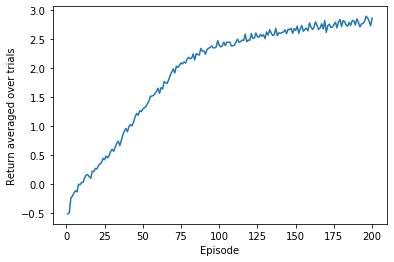

In [17]:
agent = FA_SARSA_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
trials = 1000
episodes = 200
returns_episodes = []
for trial in tqdm(range(trials)):
    returns = agent.play(gridworld, episodes = episodes)
    returns_episodes.append(returns)
    agent.reset(gridworld)
    
returns_episodes = np.array(returns_episodes)
returns_episodes = np.mean(returns_episodes, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

In [18]:
returns_comp['FA_SARSA'] = returns_episodes

#### Optimal Policy learnt by linear function approximation SARSA

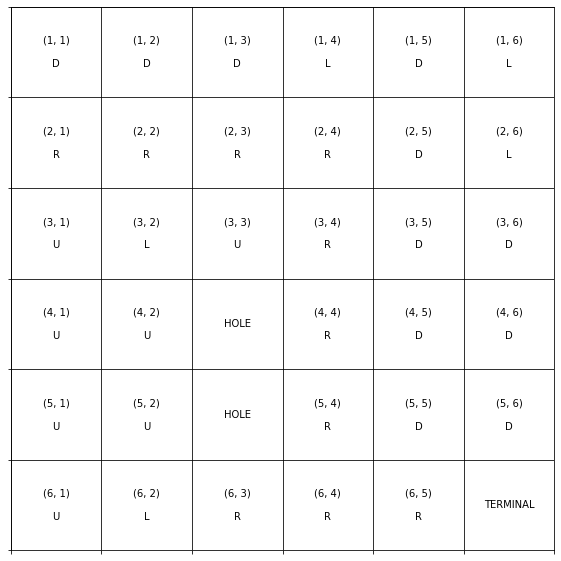

In [19]:
agent = FA_SARSA_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
agent.play(gridworld, episodes = 200)
agent.plot_optimal_policy(gridworld)

### 4) Linear Function approximation Q_Learning

In [20]:
#building the Q learning agent using linear function approximation
class FA_Q_Agent:
    def __init__(self, alpha, gamma, epsilon, env):
        #initializing the parameters of the agent
        self.actions = ['L','R','U','D'] #possible actions
        self.action_index = {'L':0, 'R':1, 'U':2, 'D':3}
        self.gamma = gamma #discount parameter
        self.alpha = alpha
        self.initial_epsilon = epsilon
        self.epsilon = self.initial_epsilon
        self.d = len(self.actions)*len(env.states)
        self.w = self.initialize_weights()
        self.state_action_map = {}
        #mapping each state action pair as a feature (identity map)
        i = 0
        for s in env.states:
            for a in self.actions:
                self.state_action_map[(s,a)] = i
                i+=1
                
    def initialize_weights(self):
        #function to initialize the weight vector
        return (np.random.normal(0, 1, size = self.d))
    
    def get_feature_vec(self, s, a):
        #function to get the feature vetor for a state action pair. 
        #Since we are using identity map as features for a state action pair, this vector is just a binary vector 
        #indicating which feature(state action pair) is present as 1 and 0 otherwise.
        
        vec = np.zeros(self.d)
        vec[self.state_action_map[(s,a)]] = 1
        return vec

    def Value_Q(self, s, a):
        #function to estimate the value of Q(s,a) given current w value.
        x = self.get_feature_vec(s, a)
        return (np.dot(self.w, x))
    
    
    def find_a_stars(self, s):
        #function to find the greedy action(s) with the highes Q(s,a) values for a given state s.
        best_q_val = -np.inf
        greedy_actions = []
        
        for a in self.actions:
            Q_sa = self.Value_Q(s, a)
            if Q_sa > best_q_val:
                best_q_val = Q_sa
                greedy_actions = [a]
            elif Q_sa == best_q_val:
                greedy_actions.append(a)
                
        return greedy_actions
    
    def reset(self, env):
        #function to reset the agent
        self.epsilon = agent.initial_epsilon
        self.w = self.initialize_weights()
        
    def choose_eps_greedy_action(self, s):
        #function to choose an action given a state s using epsilon greedy
        best_values = []
        p = random.random()
        
        if p<=self.epsilon:
            #choose a random action
            a = np.random.choice(self.actions)
        else:
            #choose greedy action based on Q values
            a_stars = self.find_a_stars(s)
            if (len(a_stars)==1): #one best action
                a = a_stars[0]
            else: #multiple optimal action. choose one randomly among them.
                a = np.random.choice(a_stars)
                
        return a
            
    def weight_update(self, env, start_state = (1,1)):
        #function to update weight vector using Q-learning
        s = start_state
        rewards = []
        
        while s!= env.terminal_state:
            #choose a using epsilon greedy policy using Q values 
            a = self.choose_eps_greedy_action(s)
            
            #observe new state s1 and reward 
            s1, r = env.get_new_state(s,a)
            
            rewards.append(r)
            
            #find action a* which has highest value Q(s1,a*, w) for the given new state s1 and current weight vector w  
            a_stars = self.find_a_stars(s1)
            a_star = a_stars[0]
            
            Q_sa = self.Value_Q(s, a)
            Q_s1a1 = self.Value_Q(s1,a_star)
            
            delta_t = (r + (self.gamma*Q_s1a1)) - Q_sa
            
            #as linear function approximation is used grad of V(s,w) is just X where X is feature representation of s
            grad_v = self.get_feature_vec(s,a)
            
            self.w = self.w + ((self.alpha*delta_t)*grad_v)
            
            s = s1
            
        G = 0
        T = len(rewards)
        for t in range(T-1, -1, -1):
            G = self.gamma * G + rewards[t]
            
        return G
        
    def play(self, env, episodes = 200):
        #function to play the agent for 200 episodes
        returns = []
        for episode_no in range(episodes):
            G = self.weight_update(env)
            returns.append(G)
            #decay epsilon 
            self.epsilon = self.initial_epsilon/np.power((episode_no + 1), 0.25)
            
        return returns
        
    def plot_optimal_policy(self, env):
        #function to plot the optimal policy learnt by the agent
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                     value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_a_stars(s)
                    value = value + '\n\n' + ','.join(move)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])

#### Learning curve for Linear function approximation Q-Learning with discounted rewards (averaged over trials) vs episode number

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:47<00:00,  3.48it/s]


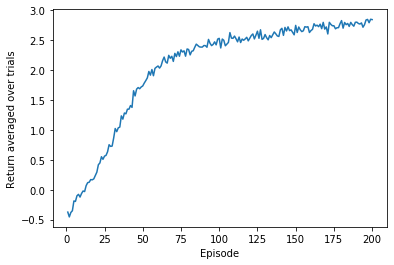

In [21]:
agent = FA_Q_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
trials = 1000
episodes = 200
returns_episodes = []
for trial in tqdm(range(trials)):
    returns = agent.play(gridworld, episodes = episodes)
    returns_episodes.append(returns)
    agent.reset(gridworld)
    
returns_episodes = np.array(returns_episodes)
returns_episodes = np.mean(returns_episodes, axis = 0)

t = np.arange(1, episodes + 1)
plt.plot(t, returns_episodes)
plt.xlabel("Episode")
plt.ylabel("Return averaged over trials")
plt.show()

In [22]:
returns_comp['FA_Q'] = returns_episodes

#### Optimal policy learnt by Linear Function approximation Q-learning after 200 episodes

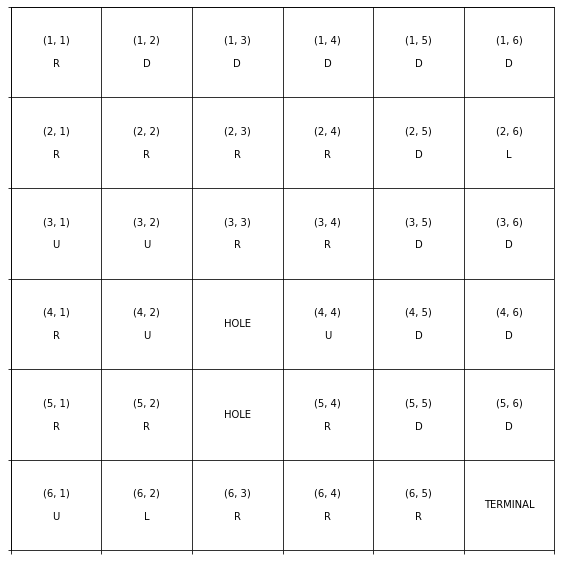

In [23]:
agent = FA_Q_Agent(alpha = 0.1, gamma = 0.9, epsilon = 0.99, env = gridworld)
agent.play(gridworld, episodes = 200)
agent.plot_optimal_policy(gridworld)

In [26]:
algorithms = list(returns_comp.keys())
algorithms

['Tabular_SARSA', 'Tabular_Q', 'FA_SARSA', 'FA_Q']

#### Comparison of learning curve for the 4 algorithms

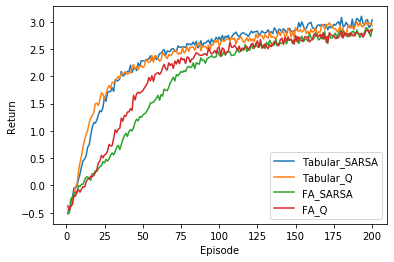

In [28]:
ts = np.arange(1, 201, 1)
for alg in algorithms:
    plt.plot(ts, returns_comp[alg], label = alg)
    
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()